In [1]:
from torch_geometric.loader import DataLoader
from Model import GraphCL
import numpy as np

import torch
from torch import optim
import time
import os
import json

from dataloader import GraphDatasetPretrain, AddRWStructEncoding
from dataloader import drop_node_augment, edge_pert_augment, attr_mask_augment, subgraph_augment

/home/cedric/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('graph_config.json') as f:
    graph_config = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

walk_length = graph_config['walk_length']
nb_epochs = graph_config['pretraining_epochs']
batch_size = graph_config['pretraining_batch_size']
learning_rate = graph_config['pretraining_lr']

In [3]:
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]

val_dataset = GraphDatasetPretrain(root='./data/', gt=gt, split='val', 
                                   graph_augment1=attr_mask_augment, graph_augment2=subgraph_augment, 
                                   aug_p=0.2, graph_transform=AddRWStructEncoding(walk_length))
train_dataset = GraphDatasetPretrain(root='./data/', gt=gt, split='train',
                                     graph_augment1=attr_mask_augment, graph_augment2=subgraph_augment,
                                     aug_p=0.2, graph_transform=AddRWStructEncoding(walk_length))

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
model = GraphCL(graph_config, 64, 128)
model.to(device)

CE = torch.nn.CrossEntropyLoss()
def contrastive_loss(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0], device=v1.device)
  return CE(logits, labels) + CE(torch.transpose(logits, 0, 1), labels)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                betas=(0.9, 0.999),
                                weight_decay=0.01)

In [5]:
params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {params:,}')

Number of parameters: 386,260


In [6]:
def train_one_epoch(model, train_loader, criterion, optimizer, losses, device, count_iter, printEvery, time1):
    loss = 0
    model.train()
    for batch in train_loader:
        aug_batch1, aug_batch2 = batch
        x_1 = model(aug_batch1.to(device))
        x_2 = model(aug_batch2.to(device))
        
        current_loss = criterion(x_1, x_2)   
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        loss += current_loss.item()
        
        count_iter += 1
        if count_iter % printEvery == 0:
            time2 = time.time()
            print("Iteration: {0}, Time: {1:.4f} s, training loss: {2:.4f}".format(count_iter,
                                                                        time2 - time1, loss/printEvery))
            losses.append(loss)
            loss = 0 

    return losses, count_iter


def eval(model, val_loader, criterion, device):
    model.eval()       
    val_loss = 0        
    for batch in val_loader:
        aug_batch1, aug_batch2 = batch
        with torch.no_grad():
            x_1 = model(aug_batch1.to(device))
            x_2 = model(aug_batch2.to(device))

            current_loss = criterion(x_1, x_2)   
            val_loss += current_loss.item()

    return val_loss

In [7]:
epoch = 0
losses = []
count_iter = 0
time1 = time.time()
printEvery = 50
best_validation_loss = 1000000

for i in range(nb_epochs):
    print('-----EPOCH {}-----'.format(i+1))
    losses, count_iter = train_one_epoch(model, train_loader, contrastive_loss, optimizer, losses, device, count_iter, printEvery, time1)

    val_loss = eval(model, val_loader, contrastive_loss, device)

    best_validation_loss = min(best_validation_loss, val_loss)

    print('-----EPOCH '+str(i+1)+'----- done.  Validation loss: ', str(val_loss/len(val_loader)) )

-----EPOCH 1-----
Iteration: 50, Time: 29.0460 s, training loss: 3.5580
Iteration: 100, Time: 57.9286 s, training loss: 1.9374
Iteration: 150, Time: 86.1851 s, training loss: 1.4801
Iteration: 200, Time: 114.4290 s, training loss: 1.2254
Iteration: 250, Time: 141.5855 s, training loss: 1.0528
Iteration: 300, Time: 168.7036 s, training loss: 1.0040
Iteration: 350, Time: 196.1512 s, training loss: 0.9999
Iteration: 400, Time: 224.4065 s, training loss: 0.9759
Iteration: 450, Time: 253.0216 s, training loss: 0.7753
Iteration: 500, Time: 280.8928 s, training loss: 0.7988
Iteration: 550, Time: 309.7913 s, training loss: 0.7355
Iteration: 600, Time: 337.5898 s, training loss: 0.7549
Iteration: 650, Time: 364.8761 s, training loss: 0.8303
Iteration: 700, Time: 394.5389 s, training loss: 0.5942
Iteration: 750, Time: 423.9180 s, training loss: 0.6129
Iteration: 800, Time: 456.3056 s, training loss: 0.5587
-----EPOCH 1----- done.  Validation loss:  0.5284083162933851
-----EPOCH 2-----
Iteration:

In [8]:
save_name = str(i) + '_' + graph_config['graph_model_name'] + '_' + str(graph_config['graph_layers']) + '_' + str(graph_config['graph_hidden_channels']) + '_' + graph_config['conv_type']

save_path = os.path.join('./graph_checkpoints', save_name +'.pt')
torch.save({
        'epoch': i,
        'model_state_dict': model.graph_base.state_dict(),
        'validation_accuracy': val_loss,
        'loss': losses[-1],
        }, save_path)
print('checkpoint saved to: {}'.format(save_path))

checkpoint saved to: ./graph_checkpoints/4_deep_20_64_Gated.pt


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [98]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_hidden, n_head, dropout):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.n_hidden = n_hidden
        self.dim_head = n_hidden//n_head

        self.Q = nn.Linear(n_hidden, self.dim_head * n_head)
        self.K = nn.Linear(n_hidden, self.dim_head * n_head)
        self.V = nn.Linear(n_hidden, self.dim_head * n_head)

        self.out_dropout = nn.Dropout(dropout)
        self.O = nn.Linear(n_hidden, n_hidden)

    def forward(self, x, attention_mask=None, padding_mask=None):
        batch_size = x.size(0)
        seq_length = x.size(1)

        Q_x = self.Q(x).view(batch_size, -1, self.n_head, self.dim_head).permute((0,2,1,3))
        K_x = self.K(x).view(batch_size, -1, self.n_head, self.dim_head).permute((0,2,1,3))
        V_x = self.K(x).view(batch_size, -1, self.n_head, self.dim_head).permute((0,2,1,3))

        padding_mask = padding_mask.view(batch_size, 1, 1, seq_length).expand(-1, self.n_head, -1, -1) * -1e9

        scores = F.softmax(padding_mask + (Q_x @ K_x.transpose(-2,-1))/np.sqrt(self.dim_head), dim=-1)

        attended_values = torch.matmul(scores, V_x)
        attended_values = attended_values.permute((0,2,1,3)).contiguous().view(batch_size, -1, self.n_hidden)

        attended_values = self.out_dropout(attended_values)
        x = self.O(attended_values)

        scores = scores.detach().cpu().numpy()

        return x, scores

In [22]:
batch = next(iter(train_loader))
batch1, batch2 = batch

In [23]:
class RWSEEncoder(nn.Module):
    def __init__(self, num_node_features, n_hidden, walk_length, dim_se, input_dropout):
        super(RWSEEncoder, self).__init__()
        self.embedding_x = nn.Linear(num_node_features, n_hidden-dim_se)
        self.norm = nn.BatchNorm1d(walk_length)
        self.embedding_se = nn.Linear(walk_length, dim_se)
        self.in_dropout = nn.Dropout(input_dropout)

    def forward(self, batch):
        rwse = batch.rwse
        rwse = self.norm(rwse)
        rwse = self.embedding_se(rwse)
        x = self.embedding_x(batch.x)
        x = torch.cat((x, rwse), 1)
        batch.x = self.in_dropout(x)
        return batch
    
enc = RWSEEncoder(300, 64, 20, 28, 0.0)
batch1 = enc(batch1)
batch1

DataBatch(x=[1267, 64], edge_index=[2, 2638], rwse=[1267, 20], batch=[1267], ptr=[33])

In [33]:
mh = nn.MultiheadAttention(64, 4, 0.0, batch_first=True)

In [99]:
mh = MultiHeadAttention(64, 4, 0.0)

In [47]:
from torch_geometric.utils import to_dense_batch
x_att, mask = to_dense_batch(batch1.x, batch1.batch)

In [100]:
out = mh(x_att, padding_mask=~mask)

In [101]:
outx, scores = out

In [104]:
outx[mask].shape

torch.Size([1267, 64])

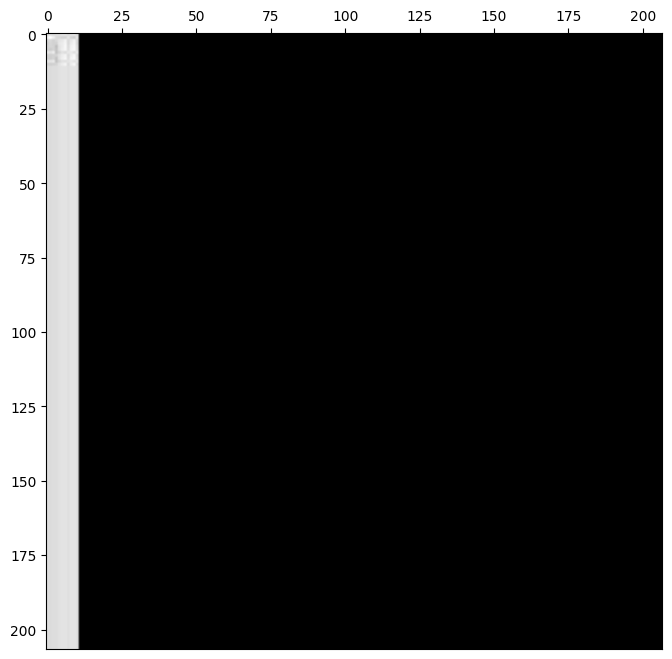

In [103]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(scores[5, 0], cmap='gray')
ax.xaxis.tick_top()

plt.show()